Author: Qiu Yang

LSTM encoder, CNN decoder

**Settings used for current result:**

toy dataset, 5000 training , 1000 testing, [X, Y, 0/1], model_1

In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
import time
import numpy as np
import random
import pickle
import os.path as path
import matplotlib.pyplot as plt
from matplotlib.path import Path
#import generate_data


In [45]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)
torch.cuda.is_available()

cuda


True

# Datasets

**2 class dataset (airplane, aircraft carrier, JP)**

In [3]:
data_path  = ''
with open(path.join(data_path,'data_X'),'rb') as f:
    X=pickle.load(f)
    
with open(path.join(data_path,'data_Y'),'rb') as f:
    Y=pickle.load(f)
    
len_train_X=int(len(X)*0.8)

train_data_raw=np.array(X[:len_train_X])
train_label=np.array(Y[:len_train_X])
test_data_raw=np.array(X[len_train_X:])
test_label=np.array(Y[len_train_X:])


print(len(train_data_raw),len(train_label))

print(len(test_data_raw),len(test_label))


93301 93301
23326 23326


**4 class dataset (toy dataset)**

In [4]:
data_path  = ''
with open(path.join(data_path,'train_X'),'rb') as f:
    X=pickle.load(f)
    
with open(path.join(data_path,'train_Y'),'rb') as f:
    Y=pickle.load(f)
    
len_train_X=int(len(X)*0.8)

train_data_raw=np.array(X[:len_train_X])
train_label=np.array(Y[:len_train_X])
test_data_raw=np.array(X[len_train_X:])
test_label=np.array(Y[len_train_X:])


print(len(train_data_raw),len(train_label))

print(len(test_data_raw),len(test_label))

21406 21406
5352 5352


**A random sample**

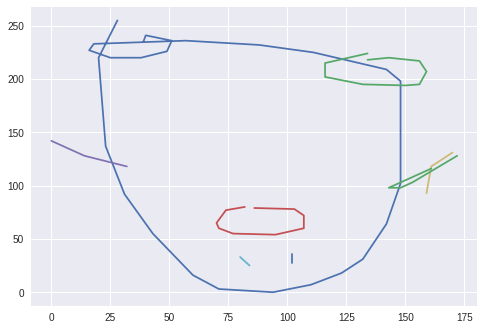

In [5]:
sketch = random.choice(train_data_raw)
for i in range(len(sketch)):
    plt.plot(sketch[i][0][:], sketch[i][1][:])
    
plt.show()

**Sub-sampling(for faster run) and reformat**

In [36]:
#sub sample for experiment
train_size=5000
test_size=1000

train_sample = train_data_raw[0:train_size]
train_label_sample = train_label[0:train_size]

test_sample = test_data_raw[0:test_size]
test_label_sample = test_label[0:test_size]
#train_sample = random.sample(list(train_data_raw),train_size)
#test_sample = random.sample(list(test_data_raw),test_size)
print(len(train_sample))

#reformat into [x,y,l]
no_point = 0;
#ave_stroke_length = 0 

def get_max_len(sub_sample):
    max_stroke_length = 0
    max_point_length = 0
    for i in range(len(sub_sample)): #each image
        if len(sub_sample[i])> max_stroke_length: 
            max_stroke_length = len(sub_sample[i])
        for j in range(len(sub_sample[i])): #each strokes
            if len(sub_sample[i][j][0])> max_point_length:
                max_point_length = len(sub_sample[i][j][0])
    return max_stroke_length,max_point_length
                
max_stroke_len,max_point_len = get_max_len(train_sample)    
print (max_stroke_len,max_point_len)
                
def process_data(sub_sample, append):
    stroke_data = []
    point_data = []
    for i in range(len(sub_sample)): #image
        for j in range(len(sub_sample[i])): #strokes
            for k in range(len(sub_sample[i][j][0])): #points
                if append:
                    if k == len(sub_sample[i][j][0])-1:
                        temp2 = [sub_sample[i][j][0][k],sub_sample[i][j][1][k],1]
                    else:
                        temp2 = [sub_sample[i][j][0][k],sub_sample[i][j][1][k],0]
                    point_data.append(temp2)
                else:
                    temp = [sub_sample[i][j][0][k],sub_sample[i][j][1][k]]
                    point_data.append(temp)
        stroke_data.append(point_data)
        point_data = []
            
    return stroke_data   

train_data = process_data(train_sample, 1)
test_data = process_data(test_sample, 1)


print (len(train_data))
print (len(test_data))

#print(no_point)
#train_data = train_data.view()

print(train_data_raw[0])
print(train_data[0])


5000
59 533
5000
1000
[[[90, 92, 101, 115, 126, 129, 130, 126, 119], [62, 88, 139, 183, 206, 202, 176, 113, 66]], [[36, 18, 1, 9, 32, 48], [64, 110, 187, 180, 134, 82]], [[35, 30, 34, 42, 49, 60, 72, 78, 91, 96], [138, 147, 171, 183, 187, 188, 181, 174, 148, 128]], [[25, 26, 22, 5, 5, 26, 18, 21, 50, 66, 86, 98, 105, 102], [149, 214, 225, 234, 239, 240, 252, 254, 255, 247, 221, 181, 144, 140]], [[105, 109, 104, 92, 72, 32, 18, 0, 24, 34, 39, 38], [64, 25, 14, 4, 0, 11, 20, 25, 28, 34, 47, 64]], [[61, 61], [20, 20]]]
[[90, 62, 0], [92, 88, 0], [101, 139, 0], [115, 183, 0], [126, 206, 0], [129, 202, 0], [130, 176, 0], [126, 113, 0], [119, 66, 1], [36, 64, 0], [18, 110, 0], [1, 187, 0], [9, 180, 0], [32, 134, 0], [48, 82, 1], [35, 138, 0], [30, 147, 0], [34, 171, 0], [42, 183, 0], [49, 187, 0], [60, 188, 0], [72, 181, 0], [78, 174, 0], [91, 148, 0], [96, 128, 1], [25, 149, 0], [26, 214, 0], [22, 225, 0], [5, 234, 0], [5, 239, 0], [26, 240, 0], [18, 252, 0], [21, 254, 0], [50, 255, 0], [66

In [37]:
#string to int label
label_set = set(train_label_sample)
label_list = list(label_set)
train_label_tensor = []
for i in range(len(train_label_sample)):
    train_label_tensor.append(label_list.index(train_label_sample[i]))
test_label_set = set(test_label)
test_label_list = list(test_label_set)
test_label_tensor = []
for i in range(len(test_label_sample)):
    test_label_tensor.append(test_label_list.index(test_label_sample[i]))  
print (len(train_label_tensor),train_label_tensor[0],len(test_label_tensor))

5000 3 1000


In [38]:
#append labels to match no.points
total_train_label = []
total_test_label = []

for i in range(len(train_data)):
    for j in range(len(train_data[i])):
        total_train_label.append(train_label_tensor[i])
        
for i in range(len(test_data)):
    for j in range(len(test_data[i])):
        total_test_label.append(test_label_tensor[i])
        
print(len(total_train_label),total_train_label[0])
print(len(total_test_label))

330386 3
64036


In [39]:
#a list of all points
train_data_points =[]
test_data_points = []

for i in range(len(train_data)):
    train_data_points.extend(train_data[i])
    
for i in range(len(test_data)):
    test_data_points.extend(test_data[i])
    
print (len(train_data_points),train_data_points[0])
print (len(test_data_points))

330386 [90, 62, 0]
64036


# Model

In [40]:
#parameters
#train
bs = 50
lr = 12
Epoch = 12
#lstm
input_size = 3
hidden_size = 300
feature_size = 64
seq_len = 1#max_stroke_length
#cnn
channels = 1 #h_seq, h_final, c_final
kernels = 50
kernel_size = 5
pool_size = 2
size_after_pool = int(bs*seq_len*hidden_size*channels*kernels/(pool_size*pool_size))
output_size = 4
temp_size = 10000

print(size_after_pool)

187500


** Model_1: one score for each point**

In [0]:
class lstm_cnn (nn.Module):

    def __init__(self):
        super(lstm_cnn, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        self.conv = nn.Conv2d(channels, kernels, kernel_size = kernel_size, padding = 1)
        self.pool = nn.MaxPool2d(pool_size, pool_size)
        #self.linear1 = nn.Linear(2500 , 2000)
        self.linear2 = nn.Linear(2700, 100)
        self.output = nn.Linear(100, output_size) 

        
    def forward(self, point_seq, h_init, c_init ):
        score_seq = torch.LongTensor([0])
        h_seq , (h_final,c_final)  =   self.lstm( point_seq , (h_init,c_init) )
        h_seq_shaped = h_seq.view(1,1,-1,hidden_size)
        #print('shape',h_seq_shaped.shape)
        for i in range(h_seq_shaped.shape[2]):
            temp = h_seq_shaped[:,:,i,:]
            temp = temp.reshape(1,1,20,15)
            temp = self.conv(temp)
            temp = F.relu(temp)
            temp = self.pool(temp)

            temp_size = torch.numel(temp)
            temp = temp.reshape(-1,temp_size)
            #temp = self.linear1(temp)
            #temp = F.relu(temp)

            temp = self.linear2(temp)
            temp = F.relu(temp)
            score = self.output(temp)
            
            if i== 0:
                score_seq = score
                #print(score_seq.shape, score_seq)
            else:
                score_seq = torch.cat((score_seq, score),0)
            #print('score_seq shape', score_seq.shape)
        return score_seq

**(WIP)  Model_2: one score fore each stroke**

In [0]:
class lstm_cnn (nn.Module):

    def __init__(self):
        super(lstm_cnn, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        self.conv = nn.Conv2d(channels, kernels, kernel_size = kernel_size, padding = 1)
        self.pool = nn.MaxPool2d(pool_size, pool_size)
        #self.linear1 = nn.Linear(2500 , 2000)
        self.linear2 = nn.Linear(1800, 100)
        self.output = nn.Linear(100, output_size) 

        
    def forward(self, input_data, h_init, c_init ):
        score_seq = torch.LongTensor([0])
        h_seq , (h_final,c_final)  =   self.lstm( input_data , (h_init,c_init) )
        #h_seq_shaped = h_seq.view(bs,channels,-1,hidden_size)
        print('shape',h_seq.shape,'final',h_final.shape)
        temp = h_seq_shaped[:,:,i,:]
        temp = temp.reshape(1,1,20,10)
        temp = self.conv(temp)
        temp = F.relu(temp)
        temp = self.pool(temp)

        temp_size = torch.numel(temp)
        temp = temp.reshape(-1,temp_size)
        #temp = self.linear1(temp)
        #temp = F.relu(temp)

        temp = self.linear2(temp)
        temp = F.relu(temp)
        score = self.output(temp)

        if i== 0:
            score_seq = score
            #print(score_seq.shape, score_seq)
        else:
            score_seq = torch.cat((score_seq, score),0)
        #print('score_seq shape', score_seq.shape)
        return score_seq

**Build the net**

In [30]:
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('There are {} ({:.2f} million) parameters in this neural network'.format(
        nb_param, nb_param/1e6)
         )

net = lstm_cnn()

print(net)

display_num_param(net)

lstm_cnn(
  (lstm): LSTM(3, 300, batch_first=True)
  (conv): Conv2d(1, 50, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear2): Linear(in_features=2700, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=4, bias=True)
)
There are 637804 (0.64 million) parameters in this neural network


In [31]:
net = net.to(device)

#net.linear.weight.data.uniform_(-0.1, 0.1)
#net.linear1.weight.data.uniform_(-0.1, 0.1)
net.linear2.weight.data.uniform_(-0.1, 0.1)
net.output.weight.data.uniform_(-0.1, 0.1)

tensor([[ 0.0353, -0.0470, -0.0785,  0.0473, -0.0040,  0.0640,  0.0076, -0.0365,
          0.0429,  0.0730,  0.0597,  0.0151, -0.0443,  0.0789,  0.0249,  0.0795,
          0.0330,  0.0012,  0.0249, -0.0459, -0.0376, -0.0431, -0.0623,  0.0117,
          0.0431, -0.0301,  0.0732, -0.0116, -0.0264,  0.0811,  0.0859,  0.0032,
         -0.0932, -0.0891, -0.0448,  0.0915, -0.0935, -0.0764,  0.0032,  0.0841,
         -0.0569,  0.0660, -0.0243,  0.0237,  0.0513,  0.0632,  0.0810, -0.0894,
         -0.0856, -0.0665,  0.0193, -0.0638, -0.0359, -0.0533, -0.0244,  0.0364,
         -0.0641, -0.0658, -0.0245,  0.0349, -0.0492, -0.0542,  0.0700,  0.0056,
         -0.0478, -0.0275,  0.0596, -0.0773,  0.0886,  0.0449,  0.0631, -0.0349,
         -0.0760, -0.0831,  0.0001, -0.0336, -0.0146,  0.0447,  0.0302,  0.0961,
          0.0772,  0.0544,  0.0640,  0.0644, -0.0059, -0.0494, -0.0705, -0.0722,
          0.0990,  0.0851, -0.0642,  0.0249, -0.0971, -0.0014,  0.0792, -0.0372,
         -0.0558,  0.0056, -

**Loss function**

In [0]:
criterion = nn.CrossEntropyLoss()


# Training and evaluation

In [0]:
def eval_on_test_set():

    running_loss=0
    num_batches=0    
    
    correct = 0
    
    correct_0 = 0
    correct_1 = 0
    correct_2 = 0
    correct_3 = 0
    
    h = torch.zeros(1, 1, hidden_size)
    c = torch.zeros(1, 1, hidden_size)
   
    h=h.to(device)
    c=c.to(device)
       
    for count in range( len(test_data)) :
               
        minibatch_data =  test_data[ count  ]
        minibatch_data = torch.Tensor(minibatch_data).view(1,-1,3)

        minibatch_label = []
        for i in range(minibatch_data.shape[1]):
            minibatch_label.append(test_label_tensor[ count ])
        
        #minibatch_label = test_label_tensor[ count  ]
        minibatch_label = torch.LongTensor([minibatch_label]).view(-1)
        
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
                                  
        scores = net( minibatch_data, h , c)
        
        #minibatch_label =   minibatch_label.view(  bs*seq_len ) 
        #scores          =            scores.view(  bs*seq_len )
        
        loss = criterion(  scores ,  minibatch_label )    
        
        h=h.detach()
        c=c.detach()
            
        running_loss += loss.item()
        num_batches += 1        
        
        scores = F.relu(scores)
        total_score = torch.sum(scores,0)   
        _, predicted = torch.max(total_score,0)
        #total += minibatch_label.size(0)
        if predicted == minibatch_label[0]:
            correct+=1
            if predicted == 0:
                correct_0+=1
            elif predicted == 1:
                correct_1+=1
            elif predicted == 2:
                correct_2+=1                
            elif predicted == 3:
                correct_3+=1        
        #print([predicted, minibatch_label[0], minibatch_label])
    
    total_loss = running_loss/num_batches 
    print('test: exp(loss) = ', math.exp(total_loss)  )
    print ('correct', correct, 'correcr_0', correct_0,'correct_1',correct_1,'correcr_2', correct_2,'correct_3',correct_3)
    print ('Test accuracy:{}%'.format(100 * correct / len(test_data)))

**Training by batch of image (not exactly by batch, append in 1 row to avoid uneven tensor shape. )**

In [44]:
# change bs above

start=time.time()

for epoch in range(Epoch):
    
    # divide the learning rate by 3 except after the first epoch
    #if epoch >= 4:
    #    lr = lr / 1.25
    #else:
    #    lr = lr / 2
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.Adam( net.parameters())# , lr=lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    num_batches=0    
       
    # set the initial h and c to be the zero vector
    h = torch.zeros( 1, 1, hidden_size)
    c = torch.zeros( 1, 1, hidden_size)

    # send them to the gpu    
    h=h.to(device)
    c=c.to(device)
    
    for count in range(0,len(train_data),bs):
        
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch
        #minibatch_data = train_data_points[count:count+bs]
        
        minibatch_data_bs =  train_data[ count:count+bs]
        
        minibatch_data = []
        for i in range(len(minibatch_data_bs)):
            for j in range (len(minibatch_data_bs[i])):
                minibatch_data.append(minibatch_data_bs[i][j])  
        
        #print (len(minibatch_data))
        
        minibatch_data = torch.Tensor(minibatch_data).view(1,-1,3)
        
        #print(minibatch_data.shape)
        #minibatch_data=minibatch_label.view(1,1,-1,200)
        #minibatch_label = train_label_tensor[ count ]
        #minibatch_label = total_train_label[count:count+bs]
        minibatch_label = []
        for k in range(len(minibatch_data_bs)):
            for l in range(len(minibatch_data_bs[k])):
                minibatch_label.append(train_label_tensor[ count+k ])
        
        #print (minibatch_label)
        
        #minibatch_label=torch.LongTensor(minibatch_label)
        minibatch_label = torch.LongTensor([minibatch_label]).view(-1)

        #print (minibatch_label.shape)
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        #print ('label shape',minibatch_label.shape)
        
        # Detach to prevent from backpropagating all the way to the beginning
        # Then tell Pytorch to start tracking all operations that will be done on h and c
        h=h.detach()
        c=c.detach()
        h=h.requires_grad_()
        c=c.requires_grad_()
                       
        # forward the minibatch through the net        
        scores = net( minibatch_data, h , c )
        
        #print (scores[0])
        
        # reshape the scores and labels to huge batch of size bs*seq_length
        #scores          =            scores.view(  bs*seq_len )  
        #minibatch_label =   minibatch_label.view(  bs*seq_len )    
        
        # Compute the average of the losses of the data points in this huge batch
        loss = criterion(  scores ,  minibatch_label )
        
        # backward pass to compute dL/dR, dL/dV and dL/dW
        loss.backward()

       
        optimizer.step()
        
            
        # update the running loss  
        running_loss += loss.item()
        num_batches += 1
        
        
        
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    elapsed = time.time()-start
    
    print('')
    print('epoch=',epoch, '\t time=', elapsed, '\t exp(loss)=',  math.exp(total_loss))
    for param_group in optimizer.param_groups:
        print('lr= ',param_group['lr'])
        
    eval_on_test_set()



epoch= 0 	 time= 979.8805589675903 	 exp(loss)= 2.439884681668551
lr=  0.001
test: exp(loss) =  2.457905613544755
correct 778 correcr_0 308 correct_1 120 correcr_2 103 correct_3 247
Test accuracy:77.8%

epoch= 1 	 time= 2044.5767273902893 	 exp(loss)= 2.317037843841241
lr=  0.001
test: exp(loss) =  2.3779727881721735
correct 786 correcr_0 321 correct_1 115 correcr_2 114 correct_3 236
Test accuracy:78.6%

epoch= 2 	 time= 3103.958749771118 	 exp(loss)= 2.2290939398683784
lr=  0.001
test: exp(loss) =  2.1797200017752725
correct 830 correcr_0 329 correct_1 125 correcr_2 104 correct_3 272
Test accuracy:83.0%

epoch= 3 	 time= 4157.154712200165 	 exp(loss)= 2.1520667437623873
lr=  0.001
test: exp(loss) =  2.164291319625073
correct 828 correcr_0 325 correct_1 122 correcr_2 110 correct_3 271
Test accuracy:82.8%

epoch= 4 	 time= 5215.088087797165 	 exp(loss)= 2.0861007336657127
lr=  0.001
test: exp(loss) =  2.100139221686308
correct 842 correcr_0 333 correct_1 133 correcr_2 109 correct_3 267

# Testing

In [0]:
test = torch.randn(2,2)
print(test.data)
test = F.relu(test)
print(test)
total =torch.sum(test, 0)

print (total)


In [0]:
print (train_label_tensor[:100])

In [0]:
filename = 'short_kanji.npz'
load_data = np.load(filename,encoding = 'latin1')
train_set = load_data['train']
valid_set = load_data['valid']
test_set = load_data['test']
print(type(train_set))
print(train_set.dtype)
print(train_set.shape)
print(random.choice(train_set))

# Histories

 **(56.76 with 2 class dataset) Training by single image**

In [0]:
start=time.time()

for epoch in range(Epoch):
    
    # divide the learning rate by 3 except after the first epoch
    if epoch >= 2:
        lr = lr / 3
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net.parameters() , lr=lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    num_batches=0    
       
    # set the initial h and c to be the zero vector
    h = torch.zeros( 1, bs, hidden_size)
    c = torch.zeros( 1, bs, hidden_size)

    # send them to the gpu    
    h=h.to(device)
    c=c.to(device)
    
    for count in range( len(train_data)):
        
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch
        minibatch_data =  train_data[ count]
        
        
        minibatch_data = torch.Tensor(minibatch_data).view(1,-1,2)
        
        #print(minibatch_data.shape)
        #minibatch_data=minibatch_label.view(1,1,-1,200)
        #minibatch_label = train_label_tensor[ count ]
        minibatch_label = []
        for i in range(minibatch_data.shape[1]):
            minibatch_label.append(train_label_tensor[ count ])
        
        #print (minibatch_label)
        
        #minibatch_label=torch.LongTensor(minibatch_label)
        minibatch_label = torch.LongTensor([minibatch_label]).view(-1)

        #print (minibatch_label)
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        #print ('label shape',minibatch_label.shape)
        
        # Detach to prevent from backpropagating all the way to the beginning
        # Then tell Pytorch to start tracking all operations that will be done on h and c
        h=h.detach()
        c=c.detach()
        h=h.requires_grad_()
        c=c.requires_grad_()
                       
        # forward the minibatch through the net        
        scores = net( minibatch_data, h , c )
        
        #print (scores[0])
        
        # reshape the scores and labels to huge batch of size bs*seq_length
        #scores          =            scores.view(  bs*seq_len )  
        #minibatch_label =   minibatch_label.view(  bs*seq_len )    
        
        # Compute the average of the losses of the data points in this huge batch
        loss = criterion(  scores ,  minibatch_label )
        
        # backward pass to compute dL/dR, dL/dV and dL/dW
        loss.backward()

       
        optimizer.step()
        
            
        # update the running loss  
        running_loss += loss.item()
        num_batches += 1
        
        
        
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    elapsed = time.time()-start
    
    print('')
    print('epoch=',epoch, '\t time=', elapsed,'\t lr=', lr, '\t exp(loss)=',  math.exp(total_loss))
    
    eval_on_test_set()
